# 🔍 Source Research for TTD Newsletter

This notebook is used to find, test, and evaluate sources of AI-related content for scraping.

👉 [📄 View source-evaluation.md](../docs/source-evaluation.md)

## 1) Analyzing already existing most popular newsletter
Found them using Google Web search and Chat GPT (1 hour research).

In [26]:
import pandas as pd
import glob
import os
import tldextract
import matplotlib.pyplot as plt
import requests
import feedparser
import re
from pprint import pprint
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from ttd.scraper.utils import extract_domain

In [2]:
# Most popular newsletter
newsletters = [
    {"Name": "AI NEWS", "URL": "https://buttondown.com/ainews/archive/", "Comments": "Maybe to use later since this is linked to reddit posts."},
    {"Name": "The Batch", "URL": "https://www.deeplearning.ai/the-batch/", "Comments": "Links to research and promotes own learning platform."},
    {"Name": "TLDR AI", "URL": "https://tldr.tech/ai/archives", "Comments": "Very good newsletter, has reading_time."},
    {"Name": "Latent Space", "URL": "https://www.latent.space/archive", "Comments": "Few links to various sources business and technical."},
    {"Name": "The Gradient", "URL": "https://thegradientpub.substack.com/s/the-update", "Comments": "Outdated and with no sources."},
    {"Name": "Papers with Code Newsletter", "URL": "https://paperswithcode.com/newsletter/", "Comments": "Outdated, only paper sources but can be user for concepts see -> https://paperswithcode.com/methods"},
    {"Name": "Ben's Bites", "URL": "https://bensbites.com/archive", "Comments": "It has interesting but very few sources."},
    {"Name": "Superhuman AI", "URL": "https://www.superhuman.ai/", "Comments": "Has a lot of crapy sources but seems to have several ai news sources."},
    {"Name": "Data Machina", "URL": "https://datamachina.com/", "Comments": "Lot of technical very intersting links."},
    {"Name": "Last Week in AI", "URL": "https://lastweekin.ai/", "Comments": "Various interesting sources."},
    {"Name": "One Useful Thing", "URL": "https://www.oneusefulthing.org/", "Comments": "No original sources."},
    {"Name": "Deep Learning Weekly", "URL": "https://www.deeplearningweekly.com/archive", "Comments": "Very good newsletter."},
    {"Name": "IMPORT AI", "URL": "https://jack-clark.net/", "Comments": "No sources."},
    {"Name": "Alpha Signal", "URL": "https://alphasignal.ai/", "Comments": "Interesting but with no archives."}
]

df = pd.DataFrame(newsletters)
# Select newsletters based on comments
selected_newsletters = df.iloc[[2,11,8,9,13]]
print(selected_newsletters)


                    Name                                         URL  \
2                TLDR AI               https://tldr.tech/ai/archives   
11  Deep Learning Weekly  https://www.deeplearningweekly.com/archive   
8           Data Machina                    https://datamachina.com/   
9        Last Week in AI                      https://lastweekin.ai/   
13          Alpha Signal                     https://alphasignal.ai/   

                                   Comments  
2   Very good newsletter, has reading_time.  
11                    Very good newsletter.  
8   Lot of technical very intersting links.  
9              Various interesting sources.  
13        Interesting but with no archives.  


#### In the end I selected 5 newsletters that should be analyzed. 

In [3]:
# Get all .json file paths
json_files = glob.glob(os.path.join("../research/data", "*.json"))

# Load and concatenate them into a single DataFrame
df = pd.concat([pd.read_json(f) for f in json_files], ignore_index=True)

# Preview
print(f"Loaded {len(df)} rows from {len(json_files)} files.")
df.head()

Loaded 8432 rows from 4 files.


,origin_url,link_url
0,https://datamachina.com/2024/01/28/data-machin...,"https://substackcdn.com/image/fetch/f_auto,q_a..."
1,https://datamachina.com/2024/01/28/data-machin...,https://www.bluesheets.ai/
2,https://datamachina.com/2024/01/28/data-machin...,https://cmu-codegen.github.io/s2024/#schedule
3,https://datamachina.com/2024/01/28/data-machin...,https://huggingface.co/blog/AviSoori1x/makemoe...
4,https://datamachina.com/2024/01/28/data-machin...,https://interworks.com/blog/2024/01/25/making-...


#### So I scraped all the articles they are presenting and now I'm focusing on their analysis

In [4]:
df["origin_domain"] = df["origin_url"].apply(extract_domain)
df["link_domain"] = df["link_url"].apply(extract_domain)

# Looking per link_domain I was able to identify interesting and bad domains.
bad_domain_list = [
    "arxiv.org",
    "github.com",
    "twitter.com",
    "reddit.com",
    "substackcdn.com",
    "google", # GOOGLE HAS TO BE CLEANED
    "github.io", 
    "technologyreview.com", # HAVE TO PAY FOR THE CONTENT
    "wired.com", # HAVE TO PAY FOR THE CONTENT
    "substack.com",
    "youtube.com",
    "openreview.net",
    "ashbyhq.com",
    "nytimes.com", # HAVE TO PAY FOR THE CONTENT
    "nature.com", # HAVE TO PAY FOR THE CONTENT
    "kaggle.com",
    "reuters.com", # HAVE TO PAY FOR THE CONTENT
    "paperswithcode.com",
    "tldr.tech",
    "cirrascale.com",
    "gitconnected.com",
    "plainenglish.io",
    "baseten.co",
    "together.ai",
    "a16z.com",
    "waymo.com",
    "betterprogramming.pub",
    "stateof.ai",
    "datadriveninvestor.com",
    "tekhnoal.com",
    "anyscale.com"
    "snorkel.ai"
]


In [8]:
domain_counts = df["link_domain"].value_counts()
domain_counts

link_domain
arxiv.org                    1125
github.com                    907
venturebeat.com               283
twitter.com                   265
huggingface.co                229
                             ... 
.wng.org                        1
emergent-misalignment.com       1
404media.co                     1
data.europa.eu                  1
unbox.ai                        1
Name: count, Length: 906, dtype: int64

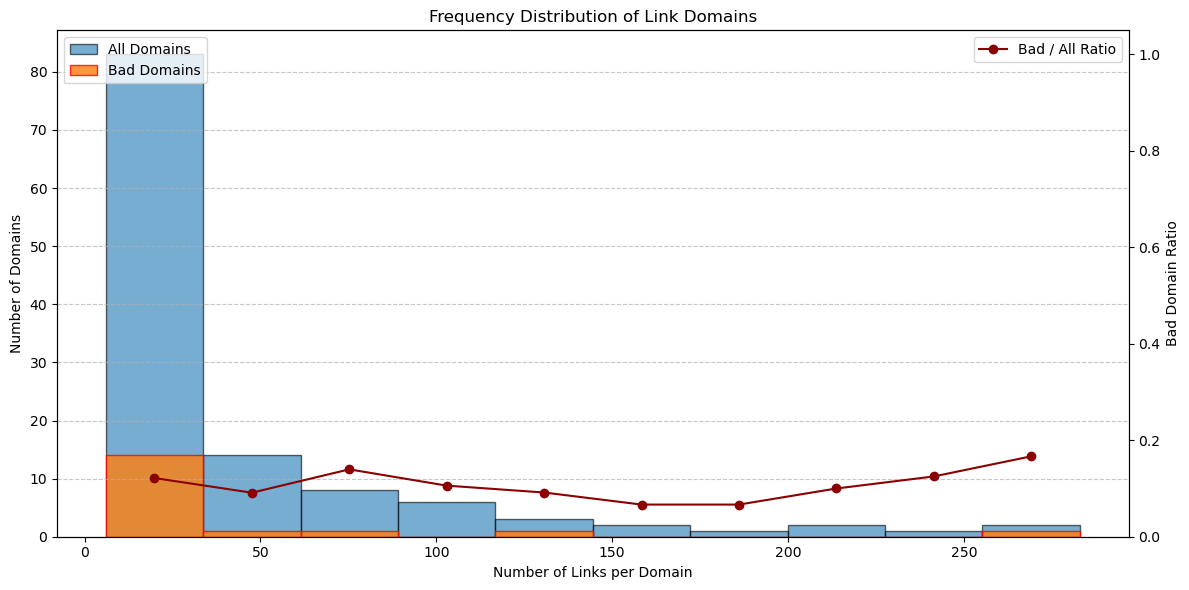

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_link_domain_distribution(
    domain_counts,
    bad_domain_list=None,
    min_links=0,
    max_links=float("inf"),
    bins=20,
    title="Frequency Distribution of Link Domains"
):
    """
    Plots a histogram of link_domain frequencies, highlighting bad domains and showing bad/all domain ratio.
    """
    # Filter domains
    filtered_counts = domain_counts[
        (domain_counts > min_links) & (domain_counts < max_links)
    ]

    # Bad domains subset
    bad_counts = pd.Series(dtype=int)
    if bad_domain_list:
        bad_counts = filtered_counts[filtered_counts.index.isin(bad_domain_list)]

    # Prepare plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # All domains histogram
    counts_all, bin_edges, _ = ax1.hist(
        filtered_counts,
        bins=bins,
        edgecolor='black',
        alpha=0.6,
        label="All Domains"
    )

    # Bad domains histogram (use same bins)
    if not bad_counts.empty:
        counts_bad, _, _ = ax1.hist(
            bad_counts,
            bins=bin_edges,
            edgecolor='red',
            alpha=0.8,
            label="Bad Domains"
        )
    else:
        counts_bad = np.zeros_like(counts_all)

    # Axis formatting
    ax1.set_xlabel("Number of Links per Domain")
    ax1.set_ylabel("Number of Domains")
    ax1.set_title(title)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.legend(loc="upper left")

    # Calculate bad-to-all domain ratio per bin
    ratio = pd.Series(
        np.divide(
            counts_bad,
            counts_all,
            out=np.zeros_like(counts_bad, dtype=float),
            where=counts_all != 0
        )
    ).rolling(window=5, center=True, min_periods=1).mean().values
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plot ratio on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(bin_centers, ratio, color='darkred', marker='o', linestyle='-', label="Bad / All Ratio")
    ax2.set_ylabel("Bad Domain Ratio")
    ax2.set_ylim(0, 1.05)
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

plot_link_domain_distribution(
    domain_counts,
    bad_domain_list=bad_domain_list,
    min_links=5,
    max_links=300,
    bins=10,
    title="Frequency Distribution of Link Domains"
)

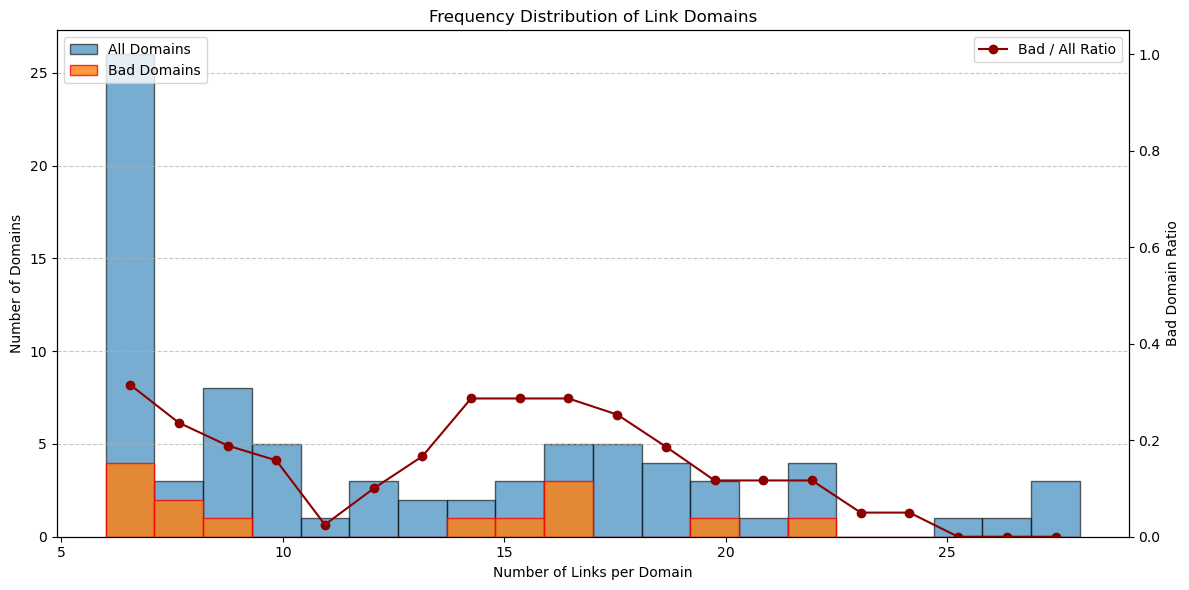

In [11]:
plot_link_domain_distribution(
    domain_counts,
    bad_domain_list=bad_domain_list,
    min_links=5, # min threshold
    max_links=30,
    bins=20,
    title="Frequency Distribution of Link Domains"
)

You can see that there are more and more bad domain names when they have less and less links attached to them. **It justifies that we stop to look for domains that appears less than 5 times**.

### We have now our domain_list that we will use to scrap automatically our articles

In [12]:
min_links=5, # min threshold
max_links=np.inf
filtered_counts = domain_counts[
        (domain_counts > min_links) & (domain_counts < max_links)
    ]
filtered_counts = filtered_counts[~filtered_counts.index.isin(bad_domain_list)]
good_articles = df[df["link_domain"].isin(filtered_counts.index)]
good_articles.to_csv('../research/data/good_articles.csv', index=False)

## 2) Good articles information extraction

In [13]:
good_articles = pd.read_csv('../research/data/good_articles.csv')
good_articles.describe()

,origin_url,link_url,origin_domain,link_domain
count,4426,4426,4426,4379
unique,322,3137,4,103
top,https://www.deeplearningweekly.com/p/1349446_d...,https://jobs.ashbyhq.com/tldr.tech,deeplearningweekly.com,venturebeat.com
freq,26,20,4046,283


In [14]:
for domain, count in good_articles.link_domain.value_counts().items():
    print(f"{domain}: {count}")

venturebeat.com: 283
huggingface.co: 229
towardsdatascience.com: 220
siliconangle.com: 207
techcrunch.com: 179
medium.com: 159
ai.googleblog.com: 158
ai.facebook.com: 143
news.mit.edu: 140
heartbeat.comet.ml: 114
blog.tensorflow.org: 107
pytorch.org: 106
openai.com: 105
theverge.com: 103
developer.nvidia.com: 98
spectrum.ieee.org: 86
comet.com: 84
neptune.ai: 84
thegradient.pub: 84
blogs.nvidia.com: 84
thenextweb.com: 78
machinelearning.apple.com: 72
aws.amazon.com: 61
mlops.community: 47
ai.meta.com: 46
heartbeat.fritz.ai: 46
eugeneyan.com: 45
philschmid.de: 44
anthropic.com: 43
syncedreview.com: 43
deepmind.com: 42
cloud.google.com: 38
blog.google: 38
colab.research.google.com: 35
edgeimpulse.com: 33
lilianweng.github.io: 31
huyenchip.com: 30
cnbc.com: 28
lightning.ai: 28
deepmind.google: 27
analyticsindiamag.com: 26
haystack.deepset.ai: 25
weaviate.io: 22
ai.stanford.edu: 22
freedium.cfd: 22
forbes.com: 21
jobs.ashbyhq.com: 20
quantamagazine.org: 20
mckinsey.com: 19
hackster.io: 19


In [16]:
for url in good_articles[good_articles.link_domain == "venturebeat.com"].link_url:
    print(url)

https://venturebeat.com/ai/google-deepmind-open-sources-alphafold-3-ushering-in-a-new-era-for-drug-discovery-and-molecular-biology/
https://venturebeat.com/ai/ai-video-rivalry-intensifies-as-luma-announces-dream-machine-api-hours-after-runway/
https://venturebeat.com/ai/nvidias-llama-3-1-minitron-4b-is-a-small-language-model-that-punches-above-its-weight/
https://venturebeat.com/games/nvidia-helps-launch-ai-platform-for-teaching-american-sign-language/?utm_source=tldrai
https://venturebeat.com/ai/nous-research-just-launched-an-api-that-gives-developers-access-to-ai-models-that-openai-and-anthropic-wont-build/?utm_source=tldrai
https://venturebeat.com/ai/cohere-releases-coral-ai-assistant-designed-for-enterprise-business-use/
https://venturebeat.com/ai/pinecone-leads-explosion-in-vector-databases-for-generative-ai/
https://venturebeat.com/ai/cohere-releases-coral-ai-assistant-designed-for-enterprise-business-use/
https://venturebeat.com/2022/01/17/new-startup-shows-how-emotion-detecting

In [43]:
good_articles.link_domain.nunique()

103

### RSS and Atom feeds

In [28]:
COMMON_FEED_PATHS = ["feed", "rss", "rss.xml", "atom.xml"]

def test_feed_url(feed_url):
    parsed = feedparser.parse(feed_url)
    return len(parsed.entries)!=0

def has_rss_or_atom_feed(base_url):
    headers = {"User-Agent": "Mozilla/5.0"}
    feed_types = ["application/rss+xml", "application/atom+xml"]


    if base_url[-1]!='/':
        base_url += '/'
    if not re.match('www.', base_url):
        base_url = 'www.' + base_url
    if not re.match('https://', base_url):
        base_url = 'https://' + base_url
    try:
        # 1. Check common feed paths
        for path in COMMON_FEED_PATHS:
            feed_url = urljoin(base_url, path)
            r = requests.get(feed_url, headers=headers, timeout=5)
            if r.status_code == 200 and "xml" in r.headers.get("Content-Type", ""):
                if test_feed_url(feed_url):
                    return True, feed_url

        # 2. Parse the homepage for <link type="application/rss+xml">
        r = requests.get(base_url, headers=headers, timeout=5)
        for link in soup.find_all("link", rel="alternate"):
            href = link.get("href", "")
            type_attr = link.get("type", "")
            if "rss" in type_attr or "atom" in type_attr or "xml" in href:
                feed_url = urljoin(base_url, href)
                if test_feed_url(feed_url):
                    return True, feed_url

    except Exception as e:
        return False, None

    return False, None

good_domains = good_articles.link_domain.value_counts().index
base_url = good_domains[0]
base_url = 'venturebeat.com'
has_rss_or_atom_feed(base_url)

(True, 'https://www.venturebeat.com/feed')

In [29]:
count = 0
good_articles['rss/atom'] = ''
for domain in good_domains:
    if domain:
        result = has_rss_or_atom_feed(domain)
        if result[0]:
            print(result)
            good_articles.loc[good_articles.link_domain==domain,'rss/atom'] = result[1]
            count += 1
print(f"Domain with rss/atom feed: {count / len(good_domains):.0%}%")

(True, 'https://www.venturebeat.com/feed')
(True, 'https://www.towardsdatascience.com/feed')
(True, 'https://www.siliconangle.com/feed')
(True, 'https://www.techcrunch.com/feed')
(True, 'https://www.theverge.com/rss.xml')
(True, 'https://www.neptune.ai/feed')
(True, 'https://www.thegradient.pub/feed')
(True, 'https://www.blogs.nvidia.com/feed')
(True, 'https://www.thenextweb.com/feed')
(True, 'https://www.aws.amazon.com/rss')
(True, 'https://www.eugeneyan.com/rss')
(True, 'https://www.philschmid.de/rss')
(True, 'https://www.syncedreview.com/feed')
(True, 'https://www.huyenchip.com/feed')
(True, 'https://www.analyticsindiamag.com/feed')
(True, 'https://www.quantamagazine.org/feed')
(True, 'https://www.mckinsey.com/rss')
(True, 'https://www.machinelearningmastery.com/feed')
(True, 'https://www.marktechpost.com/feed')
(True, 'https://www.pyimagesearch.com/feed')
(True, 'https://www.techrepublic.com/feed')
(True, 'https://www.dagster.io/rss.xml')
(True, 'https://www.arstechnica.com/feed')


In [31]:
print(f"Domain with rss/atom feed: {count / len(good_domains):.0%}%")

Domain with rss/atom feed: 33%%


In [32]:
count = sum(good_articles['rss/atom']!='')
print(f"Articles with rss/atom feed: {count / len(good_articles):.0%}")

Articles with rss/atom feed: 40%


In [33]:
good_articles.to_csv('../research/data/good_articles.csv', index=False)

In [41]:
# Fields we want to check
required_fields = ["title", "published", "author", "tags", "summary", "source_url"]

# Helper function to safely check field presence
def check_entry_fields(entry):
    return {
        "title": bool(entry.get("title")),
        "published": bool(entry.get("published", entry.get("updated"))),
        "author": bool(entry.get("author", entry.get("dc:creator"))),
        "tags": bool(entry.get("tags", [])),
        "summary": bool(entry.get("summary", entry.get("description"))),
        "source_url": bool(entry.get("link"))
    }
def check_ai_is_in_tags(entries):
    for entry in entries:
        is_ai = False
        if bool(entry.get("tags")):
            for tag in entry["tags"]:
                if re.match(r'(\W|^)ai(\W|$)', tag['term'], re.I):
                    is_ai = True
                    return True
    return False

# Initialize field presence counters
field_stats = {field: 0 for field in required_fields}
feeds = good_articles.loc[good_articles['rss/atom']!='','rss/atom'].unique()
for feed in feeds:
    parsed = feedparser.parse(feed)
    if len(parsed.entries)!=0:
        entry = parsed.entries[0]
        results = check_entry_fields(entry)
        if results['tags']:
            results['tags'] = check_ai_is_in_tags(parsed.entries)
        print(feed)
        pprint(results)
        for field in required_fields:
            field_stats[field] += results[field]
    else:
        print(f"No entries in '{feed}'")
for field in required_fields:
    field_stats[field] /= len(feeds)
    print(f"{field} presence's rate: {field_stats[field]:.0%}")


https://www.neptune.ai/feed
{'author': True,
 'published': True,
 'source_url': True,
 'summary': True,
 'tags': False,
 'title': True}
https://www.aws.amazon.com/rss
{'author': True,
 'published': True,
 'source_url': True,
 'summary': True,
 'tags': False,
 'title': True}
https://www.quantamagazine.org/feed
{'author': True,
 'published': True,
 'source_url': True,
 'summary': True,
 'tags': False,
 'title': True}
https://www.eugeneyan.com/rss
{'author': False,
 'published': True,
 'source_url': True,
 'summary': True,
 'tags': False,
 'title': True}
https://www.huyenchip.com/feed
{'author': False,
 'published': True,
 'source_url': True,
 'summary': True,
 'tags': False,
 'title': True}
https://www.marktechpost.com/feed
{'author': True,
 'published': True,
 'source_url': True,
 'summary': True,
 'tags': True,
 'title': True}
https://www.theverge.com/rss.xml
{'author': True,
 'published': True,
 'source_url': True,
 'summary': True,
 'tags': True,
 'title': True}
https://www.techcrunc

In [42]:
feeds = good_articles.loc[good_articles['rss/atom']!='','rss/atom'].unique()
feeds

array(['https://www.neptune.ai/feed', 'https://www.aws.amazon.com/rss',
       'https://www.quantamagazine.org/feed',
       'https://www.eugeneyan.com/rss', 'https://www.huyenchip.com/feed',
       'https://www.marktechpost.com/feed',
       'https://www.theverge.com/rss.xml',
       'https://www.techcrunch.com/feed',
       'https://www.arstechnica.com/feed',
       'https://www.theguardian.com/rss', 'https://www.zdnet.com/rss.xml',
       'https://www.siliconangle.com/feed',
       'https://www.analyticsindiamag.com/feed',
       'https://www.engadget.com/rss', 'https://www.venturebeat.com/feed',
       'https://www.anyscale.com/rss.xml',
       'https://www.blogs.nvidia.com/feed',
       'https://www.dagster.io/rss.xml', 'https://www.philschmid.de/rss',
       'https://www.thegradient.pub/feed',
       'https://www.towardsdatascience.com/feed',
       'https://www.thenextweb.com/feed',
       'https://www.syncedreview.com/feed',
       'https://www.techrepublic.com/feed',
       'h

- We have 33% domains among the 103 selected good domains that have RSS feed.
- They represent 40% of all the articles.
- They all have a title, a published date, and a source_url.
- 79% have an author.
- 97% have a summary.
- 47% have tags.


In [44]:
# Write the feeds
with open("../data/rss_feeds.txt", "w") as f:
    for feed in feeds:
        f.write(feed.strip() + "\n")